# Análisis de sentimiento con comentarios de Twitter
El análisis de sentimientos, una técnica clave en el procesamiento de lenguaje natural permitiendo a las empresas y organizaciones entender opiniones y emociones expresadas en texto de manera automatizada. Con los miles de datos que se generan en redes sociales y otras plataformas tener modelos que procesen y analicen estos datos es crucial para mejorar la toma de decisiones, aumentar la satisfacción del cliente y comprender tendencias sociales. Sin embargo, esta tarea no es tan fácil debido a la complejidad del lenguaje humano, ya sea como el sarcasmo o la ambigüedad, lo que hace necesario desarrollar modelos precisos y robustos que puedan manejar estas sutilezas para convertir grandes volúmenes de datos en información accionable.

Para poder abordar este problema se utilizara un dataset que contiene miles de comentarios de la red social Twitter los cuales estan etiquetados por sentimiento (positivo, neutral, negativo).

# Importar librerias
Se importan las librerias necesarias para el proceso

In [2]:
# Manipulación de datos y carga de archivo
import pandas as pd
import numpy as np
import tensorflow as tf

# Preprocesamiento de texto
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Construcción del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout

# Procesamiento de datos
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Construcción del modelo
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Mostrar resultados
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Manipulación de archivos
from google.colab import files
import pickle

# Datos

Como se menciono anteriormente para este proyecto se selecciono el Twitter Sentiment Analysis Dataset obtenido de Kaggle, es una base de datos compuesta por tweets etiquetados por categorías de sentimiento: positivo, negativo y neutral. La información de los tweets se obtiene de una colección extensa de interacciones en Twitter, permitiendo evaluar el sentimiento general en esta red social y representando el lenguaje informal y dinámico ya que simula la forma en que los usuarios interactúan en tiempo real en las redes.
El Dataset cuenta con:


*   162,980 datos
*   35,509 datos son negativos
*   55,212 datos son neutrales
*   72,249 datos son positivos

Este desbalance de clases puede llegar a afectar el desempeño del modelo.

Link del Dataset en kaggle:
https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv


In [ ]:
data = pd.read_csv("Twitter_Data.csv")
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


El Dataset está estructurado con etiquetas numéricas (-1: negativo, 0: neutral y 1: positivo) y una columna de texto (clean_text) que contiene los mensajes de cada tweet ya procesados. Es fundamental limpiar y normalizar el texto, eliminando caracteres irrelevantes para facilitar su procesamiento. El análisis presenta desafíos, como la interpretación de jerga, abreviaturas, emojis y el contexto, que puede incluir sarcasmo y ambigüedad. Este dataset se utiliza principalmente para clasificar sentimientos, permitiendo analizar tendencias y opiniones en tiempo real, con aplicaciones prácticas en redes sociales y marketing para medir la percepción pública y la satisfacción de los usuarios.

# Limpiar datos

In [ ]:
# Verificar si hay valores nulos
print(data.isnull().sum())
print("Número de filas:", data.shape[0])

clean_text    4
category      7
dtype: int64
Número de filas: 162980


Como tenemos valores nulos vamos a requerir hacer limpieza de estos, como son 162,980 datos y solo son 11 valores nulos no afectara mucho si eliminamos estas filas.

In [ ]:
# Eliminar filas con valores nulos
data = data.dropna()
# Verificar si se eliminaron los valores nulos
print(data.isnull().sum())
# Verificar el número de filas
print("Número de filas:", data.shape[0])

clean_text    0
category      0
dtype: int64
Número de filas: 162969


Para poder tener un mejor analisis del texto se eliman los caracteres inecesarios porque ayuda a que el texto sea más consistente y reduce el ruido en los datos.

In [ ]:
data['clean_text'] = data['clean_text'].str.replace('\n', '').str.replace('\r', '').str.replace('\ufeff', '').str.replace('“','').str.replace('”','')

In [ ]:
data['clean_text'][0]

'when modi promised minimum government maximum governance expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

# Procesamiento de datos

El primer paso es tokenizar los datos, este es un paso esencial en el procesamiento de lenguaje natural (NLP) que convierte el texto en un formato que un modelo de machine learning puede entender. La tokenización es el proceso de dividir el texto en unidades más pequeñas llamadas tokens. Por ejemplo [ "when", "modi", "promised", "minimum", "government", ...] Luego sigue la indexación que se basa en ponerle números a las palabras para luego generar una secuencia númerica y finalmente hacerle padding a las necesarias.

In [ ]:
# Para la salida se convierten las etiquetas a formato categórico
labels = pd.get_dummies(data['category']).values

# Se tokenizan los datos y se indexan
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean_text'])

# Se convierte en secuencia númerica y se aplica padding
sequences = tokenizer.texts_to_sequences(data['clean_text'])
padded_sequences = pad_sequences(sequences)


In [ ]:
padded_sequences.shape

(162969, 52)

# Construcción del modelo

Para la construcción del modelo primero necesitamos obtener los parámetros de entrada del modelo, la primera capa va ser una de Embedding que convierte los tokens en vectores densos de dimensiones fijas, permitiendo que las palabras se representen en un espacio continuo y que el modelo "entienda" relaciones entre ellas. A esta capa se le dara el tamaño del vocabulario (cuantas palabras unicas hay), luego se le dara las dimensiones que tendrá cada vector de palabra y finalmente la longitud de las secuencias después de aplicar padding como la longitud de entrada.
Luego aplicamos una capa Convolución lo que hace que detecte patrones locales en las secuencias, como ciertas combinaciones de palabras que pueden ser significativas para el sentimiento. El 2 representa el número de filtros de convolución (o características) que el modelo aprende en esta capa, el 10 es el tamaño de cada filtro, en este caso, el modelo examina conjuntos de 10 palabras adyacentes para buscar patrones y "relu" es su función de activación.
Luego se aplica una capa de Dropout para evitar el sobreajuste en el modelo.
La siguiente capa es la de MaxPooling que su función es reducir la dimensionalidad de las características aprendidas, seleccionando solo el valor máximo en cada "ventana" de características, el modelo selecciona el valor máximo de cada 15 características adyacentes.
Luego la capa LSTM es una red neuronal recurrente (RNN) que sirve para manejar secuencias de datos, permitiendo que el modelo retenga información sobre el contexto de las palabras a lo largo de la secuencia.
Finalmente se agrega una capa densa para la predicción final del modelo con 3 neuronas una para cada sentimiento y la función de activación softmax que convierte los valores de salida en probabilidades.

In [ ]:
# Se divide el dataset en padding
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.4, random_state=42)

# Parámetros del modelo
vocab_size = len(tokenizer.word_index) + 1  # tamaño del vocabulario
embedding_dim = 10                          # dimensión de la capa de embedding
max_length = padded_sequences.shape[1]      # longitud de secuencias

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(2, 10, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=15))
model.add(LSTM(4))
model.add(Dense(3, activation='softmax'))   # 3 clases para análisis de sentimientos (-1, 0, 1)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo

Para entrenar el modelo se requiere darle los valores de entrada (comanetarios-padded_sequences) y de salida (sentimientos-labels), el número de epocas para entrenar, el tamaño del batch y la división para el conjunto de validación.

In [ ]:
history = model.fit(
    padded_sequences,       # Secuencias de entrada preprocesadas
    labels,                 # Etiquetas de sentimientos
    epochs=10,              # Número de épocas
    batch_size=16,          # Tamaño del lote
    validation_split=0.2,   # Fracción del conjunto de datos para validación
)

Epoch 1/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 69s 7ms/step - accuracy: 0.5111 - loss: 0.9843 - val_accuracy: 0.5396 - val_loss: 0.9391
Epoch 2/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.5660 - loss: 0.8846 - val_accuracy: 0.4932 - val_loss: 0.9703
Epoch 3/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.5929 - loss: 0.8536 - val_accuracy: 0.4748 - val_loss: 1.0183
Epoch 4/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.6215 - loss: 0.8157 - val_accuracy: 0.4908 - val_loss: 1.0012
Epoch 5/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - accuracy: 0.6378 - loss: 0.7902 - val_accuracy: 0.4918 - val_loss: 1.0235
Epoch 6/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.6501 - loss: 0.7697 - val_accuracy: 0.4945 - val_loss: 1.0358
Epoch 7/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.6632 - loss: 0.7495 - val_accuracy: 0.5081 - val_loss: 1.0090
Epoch 8/10
8149/8149 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.6696 - loss: 0

# Resultados

Checamos el accuracy con el conjunto de test separado anteriormente

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2038/2038 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6085 - loss: 0.8732
Test Accuracy: 60.80%


Graficamos el accuracy de los datos de entrenamiento y validación

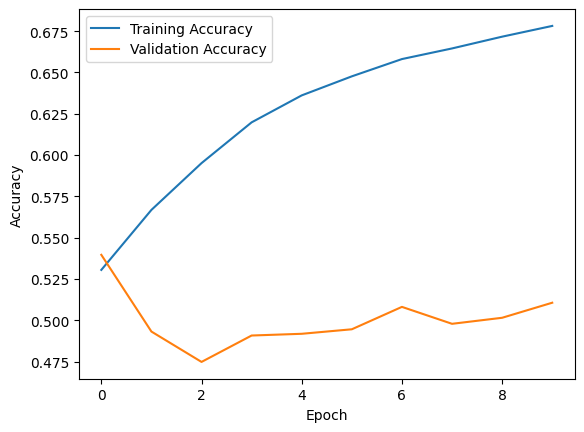

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Finalmente generamos predicciones con el conjunto de test para obtener el reporte de clasificación y la matriz de confusión.

In [ ]:
# Generar predicciones en el conjunto de prueba
predicciones = model.predict(X_test)
predicted_classes = predicciones.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

# Calcular el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=["Negativo", "Neutral", "Positivo"]))

# Calcular la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(true_classes, predicted_classes))

2038/2038 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.52      0.60      0.56     14248
     Neutral       0.56      0.95      0.70     22161
    Positivo       0.89      0.35      0.50     28779

    accuracy                           0.61     65188
   macro avg       0.66      0.63      0.59     65188
weighted avg       0.70      0.61      0.58     65188

Matriz de Confusión:
[[ 8514  5135   599]
 [  469 21008   684]
 [ 7321 11348 10110]]


Podemos observar que la presición del modelo salio muy bajo y en la gráfica se puede observar que se sobreajusto un poco. El modelo tiene un rendimiento malo con una precisión general de 0.67. La clase "Neutral" es la mejor manejada, con un alto recall de 0.97, pero las clases "Negativo" y "Positivo" tienen un recall bajo de 0.50 y 0.52, indicando muchos falsos negativos. La precisión es alta para "Positivo" con 0.90, pero baja para "Neutral" con 0.54. Aunque el modelo predice bien los casos neutrales, existe un desequilibrio en el desempeño entre las clases.

# Nuevo modelo

Para este nuevo modelo lo que se ajusto fue:

*   La dimensión de la capa de embedding aumento a 100 ya que mientras mas alto sea el valor le va a permitir que las palabras se representen con mayor detalle
*   Tambien aumento a 128 el número de filtros de convolución (o características) que el modelo aprende en esta capa y cambiamos a 5 el número de palabras adyacentes a examinar para obtener más características.
*   Se agregaron más capas de Dropout y se reduce su porcentaje de apagado para que ayude a prevenir el sobreajuste
*   Se aumento a 64 las unidades de la LSTM lo que aumenta la capacidad de la red para capturar información secuencial y para que aprenda mejor los padtrones se activa el "return_sequences" lo que devuelve toda la secuencia de salida, en lugar de solo el último estado.
*   Finalmente se se agrega una segunda capa LSTM que ayuda a procesar la secuencia a un nivel más alto, mejorando la capacidad del modelo para hacer predicciones de sentimiento con contexto adicional.



In [ ]:
# Parámetros del modelo
vocab_size = len(tokenizer.word_index) + 1  # tamaño del vocabulario
embedding_dim = 100  # dimensión de la capa de embedding
max_length = padded_sequences.shape[1]  # longitud de secuencias

model_bueno = Sequential()
model_bueno.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_bueno.add(Conv1D(16, 5, activation='relu'))
model_bueno.add(MaxPooling1D(pool_size=5))
model_bueno.add(Dropout(0.2))
model_bueno.add(LSTM(32, return_sequences=True))
model_bueno.add(Dropout(0.2))
model_bueno.add(LSTM(16))
model_bueno.add(Dropout(0.2))
model_bueno.add(Dense(3, activation='softmax'))  # 3 clases para análisis de sentimientos (-1, 0, 1)

model_bueno.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_bueno.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar modelo

En el entrenamiento del modelo para que no sufra sobreajuste se puso un early stop que se detiene cuando la perdida del conjunto de validación no cambia y restaura los mejores psos del modelo.
De igual manera se redujo el batch_size para que pueda mejorar el aprendizaje del modelo.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',  # La métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    restore_best_weights=True  # Restaurar los pesos del modelo de la época con mejor desempeño
)

# Entrenar el modelo
history = model_bueno.fit(
    padded_sequences,       # Tus secuencias de entrada preprocesadas
    labels,                 # Etiquetas del conjunto de entrenamiento
    epochs=10,              # Número máximo de épocas
    batch_size=64,          # Tamaño del lote
    validation_split=0.2,   # Fracción del conjunto de datos para validación
    callbacks=[early_stop]  # Incluir el callback de EarlyStopping
)

Epoch 1/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.6915 - loss: 0.7274 - val_accuracy: 0.8621 - val_loss: 0.4288
Epoch 2/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8728 - loss: 0.4018 - val_accuracy: 0.8593 - val_loss: 0.4328
Epoch 3/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8982 - loss: 0.3270 - val_accuracy: 0.8524 - val_loss: 0.4563
Epoch 4/10
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9184 - loss: 0.2630 - val_accuracy: 0.8413 - val_loss: 0.5276


# Resultados

In [ ]:
test_loss, test_accuracy = model_bueno.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2038/2038 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8747 - loss: 0.3963
Test Accuracy: 87.52%


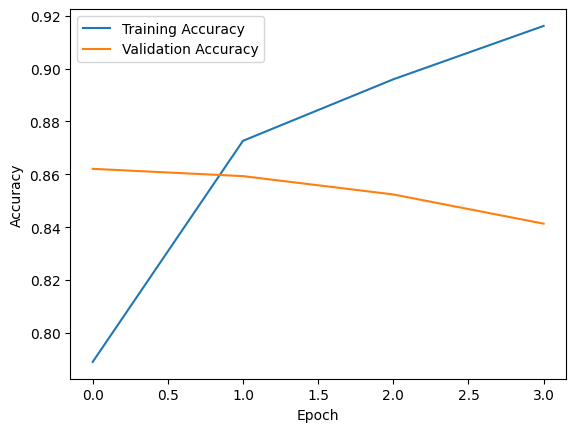

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Generar predicciones en el conjunto de prueba
predicciones = model_bueno.predict(X_test)
predicted_classes = predicciones.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

# Calcular el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=["Negativo", "Neutral", "Positivo"]))

# Calcular la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(true_classes, predicted_classes))

2038/2038 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.87      0.81      0.84     14248
     Neutral       0.81      0.97      0.88     22161
    Positivo       0.95      0.83      0.89     28779

    accuracy                           0.88     65188
   macro avg       0.88      0.87      0.87     65188
weighted avg       0.88      0.88      0.87     65188

Matriz de Confusión:
[[11562  1686  1000]
 [  319 21558   284]
 [ 1431  3415 23933]]


A diferencia del anterior modelos se puede observar como el Accuracy con el conjunto de prueba llega a ser alto, sin embargo en la grafica de la presición de los datos de entrenamiento y validación se puede observar una gran discrepancia lo que significa que se esta sobreajustando. En cuanto a precision, recall y f1-score todos los valores que indican un buen desempeño pero se observa que a la clase Negativo presenta un desempeño inferior en comparación con las otras categorías, lo cual sugiere que el modelo tiene dificultades para diferenciar correctamente los tweets negativos. En la matriz de confusión podemos observar que ahora se confunde menos que el anterior modelo pero la clase que más se llega a equivocar es la "Neutral" con muchas más clasificaciones equivocadas.

Para mejorar el modelo, se podría aumentar la cantidad de datos de entrenamiento para la clase "Negativo" y "Neutral" aplicando técnicas de data augmentation u obteniendo más conversaciones, esto para que las clases esten más balanceadas y pueda tener un mejor desempeño. De igual manera se puede ajustar el modelo para reducir el sobreajuste, ya sea cambiando los hiperparamentros de  los dropout en el modelo, ajustando en el tamaño del batch size o reducir la complejidad del modelo.

In [ ]:
# Guardar el modelo completo (arquitectura + pesos)
model_bueno.save('/content/full_model.keras')

# Guardar el tokenizador
with open('/content/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Pruebas
Una vez guardado el modelo y el tokenizador se va a probar el modelo con nuevos datos

In [8]:
# Cargar el modelo bueno
model = tf.keras.models.load_model('/content/full_model.keras')

def preprocess_text(text):
    # Eliminar caracteres no deseados y limpiar el texto
    text = re.sub(r'\n|\r|\ufeff|“|”', '', text)
    return text

def classify_text(text):

    clean_text = preprocess_text(text)

    # Cargar el tokenizador usado
    with open('/content/tokenizer.pkl', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Convertir el texto a secuencia numérica
    sequences = tokenizer.texts_to_sequences([clean_text])
    padded_sequences = pad_sequences(sequences)

    # Realizar la predicción
    prediction = model.predict(padded_sequences)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapeo de clases
    class_labels = {0: "Negativo", 1: "Neutral", 2: "Positivo"}  # Ajusta según las clases de tu modelo
    return class_labels[predicted_class]

# Primer ejemplo positivo
texto = "With all this nonsense and continue with all the drama"
resultado = classify_text(texto)
print("El sentimiento del primer tweet es:", resultado)

# Segundo ejemplo Neutral
texto = "one vote can make all the difference in election 2019"
resultado = classify_text(texto)
print("El sentimiento del segundo tweet es:", resultado)

# Tercer ejemplo Negativo
texto = "The government's promise of reducing bureaucracy and streamlining operations has been slow state should and not business and should exit psus and temples."
resultado = classify_text(texto)
print("El sentimiento del segundo tweet es:", resultado)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
El sentimiento del primer tweet es: Positivo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
El sentimiento del segundo tweet es: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
El sentimiento del segundo tweet es: Negativo
